## 290 - Calculating and Plotting Height Changes from the GFS

[Youtube](https://www.youtube.com/watch?v=uZIC8nAxSzY)

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.catalog import TDSCatalog

In [2]:
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')

In [3]:
print(list(best_gfs.datasets))

['Best GFS Quarter Degree Forecast Time Series']


In [4]:
best_ds = best_gfs.datasets[0]
ncss = best_ds.subset()

In [5]:
query = ncss.query()
query.lonlat_box(north=55, south=20, east=290, west=235)
query.accept('netcdf4')
query.variables('Geopotential_height_isobaric')
query.vertical_level(50000)
now = datetime.utcnow()
query.time_range(now, now + timedelta(days=1))

var=Geopotential_height_isobaric&time_start=2023-06-26T14%3A34%3A43.434832&time_end=2023-06-27T14%3A34%3A43.434832&west=235&east=290&south=20&north=55&accept=netcdf4&vertCoord=50000

In [6]:
data = ncss.get_data(query)
print(list(data.variables))

['reftime', 'latitude', 'time', 'isobaric', 'longitude', 'Geopotential_height_isobaric', 'LatLon_721X1440-0p13S-180p00E-2']


In [7]:
height_var = data['Geopotential_height_isobaric']
time_var = data['time']
lat_var = data['latitude']
lon_var = data['longitude']

height_vals = height_var[:].squeeze()
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()
time_vals = num2date(time_var[:].squeeze(), time_var.units)

lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

Text(0.5, 1.0, '24 Hour GFS 500 hPa Height Change')

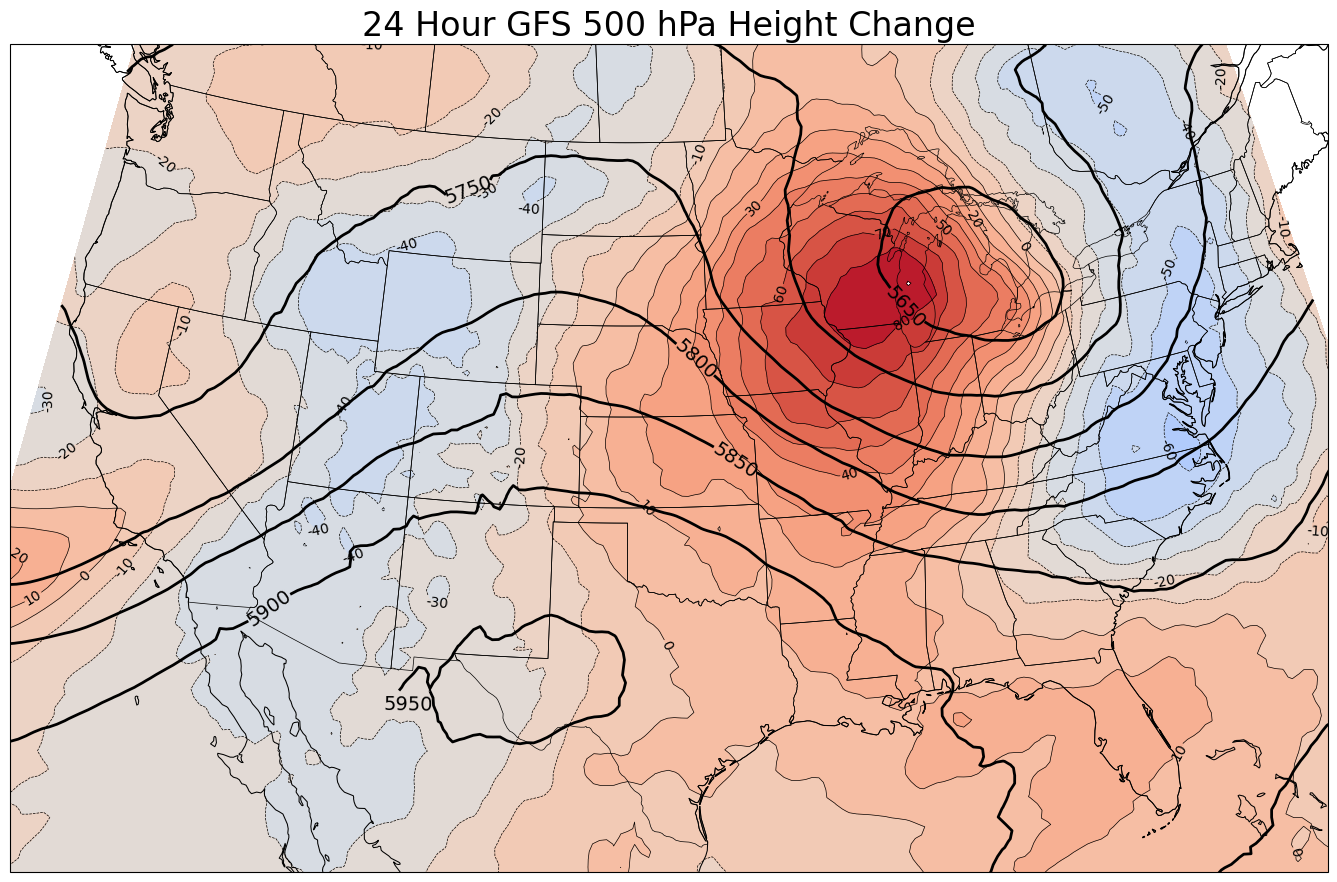

In [8]:
crs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)
bounds = [(-122, -75, 25, 50)]

fig = plt.figure(figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

c_height = ax.contour(lon_2d, lat_2d, height_vals[0, :, :], colors='black', linewidths=2,
                      transform=ccrs.PlateCarree())

falls = height_vals[-1, :, :] - height_vals[0, :, :]

c_falls = ax.contour(lon_2d, lat_2d, falls, colors='black', linewidths=0.5,
                      transform=ccrs.PlateCarree(), levels=np.arange(-150, 100, 10))

cf_falls = ax.contourf(lon_2d, lat_2d, falls,
                      transform=ccrs.PlateCarree(), levels=np.arange(-150, 100, 10),
                      cmap='coolwarm')

ax.clabel(c_height, fontsize=14, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
ax.clabel(c_falls, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
ax.set_title('24 Hour GFS 500 hPa Height Change', fontsize=24)